In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np 
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# input the data
data = pd.read_csv('Restaurant_Reviews.tsv', sep ='\t')
# Take the choosen columns
data = data[['Review','Liked']]

In [3]:
print(data)

print(data.shape)

print(data.isnull().sum())

                                                Review  Liked
0                             Wow... Loved this place.      1
1                                   Crust is not good.      0
2            Not tasty and the texture was just nasty.      0
3    Stopped by during the late May bank holiday of...      1
4    The selection on the menu was great and so wer...      1
..                                                 ...    ...
995  I think food should have flavor and texture an...      0
996                           Appetite instantly gone.      0
997  Overall I was not impressed and would not go b...      0
998  The whole experience was underwhelming, and I ...      0
999  Then, as if I hadn't wasted enough of my life ...      0

[1000 rows x 2 columns]
(1000, 2)
Review    0
Liked     0
dtype: int64


# Preprocessing

In [4]:
data['Review'] = data['Review'].apply(lambda x: x.lower())
data['Review'] = data['Review'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

print(data[ data['Liked'] == 1].size)
print(data[ data['Liked'] == 0].size)
    
max_features = 300
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(data['Review'].values)
X = tokenizer.texts_to_sequences(data['Review'].values)
X = pad_sequences(X)

1000
1000


# Building Model Architecture

In [5]:
embed_dim = 32
lstm_out = 32

model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.4, recurrent_dropout=0.4))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 26, 32)            9600      
                                                                 
 spatial_dropout1d (Spatial  (None, 26, 32)            0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 2)                 66        
                                                                 
Total params: 17986 (70.26 KB)
Trainable params: 17986 (70.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


# Splitting dataset

In [6]:
Y = pd.get_dummies(data['Liked']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.30, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(700, 26) (700, 2)
(300, 26) (300, 2)


In [7]:
validation_size = len(X_test) // 2

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]

# Training

In [8]:
batch_size = 32
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(X_train, Y_train, epochs = 20, batch_size=batch_size, verbose = 2, validation_data=(X_validate, Y_validate), callbacks=[early_stopping])

Epoch 1/20


22/22 - 13s - loss: 0.6917 - accuracy: 0.5214 - val_loss: 0.6920 - val_accuracy: 0.4533 - 13s/epoch - 592ms/step
Epoch 2/20
22/22 - 1s - loss: 0.6852 - accuracy: 0.6143 - val_loss: 0.6833 - val_accuracy: 0.6200 - 913ms/epoch - 42ms/step
Epoch 3/20
22/22 - 1s - loss: 0.6730 - accuracy: 0.6214 - val_loss: 0.6625 - val_accuracy: 0.7067 - 900ms/epoch - 41ms/step
Epoch 4/20
22/22 - 1s - loss: 0.6437 - accuracy: 0.6929 - val_loss: 0.6124 - val_accuracy: 0.7667 - 901ms/epoch - 41ms/step
Epoch 5/20
22/22 - 1s - loss: 0.5921 - accuracy: 0.7386 - val_loss: 0.5536 - val_accuracy: 0.7133 - 934ms/epoch - 42ms/step
Epoch 6/20
22/22 - 1s - loss: 0.5116 - accuracy: 0.7900 - val_loss: 0.4764 - val_accuracy: 0.7867 - 938ms/epoch - 43ms/step
Epoch 7/20
22/22 - 1s - loss: 0.4460 - accuracy: 0.7971 - val_loss: 0.4179 - val_accuracy: 0.7867 - 1s/epoch - 52ms/step
Epoch 8/20
22/22 - 1s - loss: 0.3925 - accuracy: 0.8457 - val_loss: 0.4154 - val_accuracy: 0.7733 - 1s/epoch - 50ms/step
Epoch 9/20
2

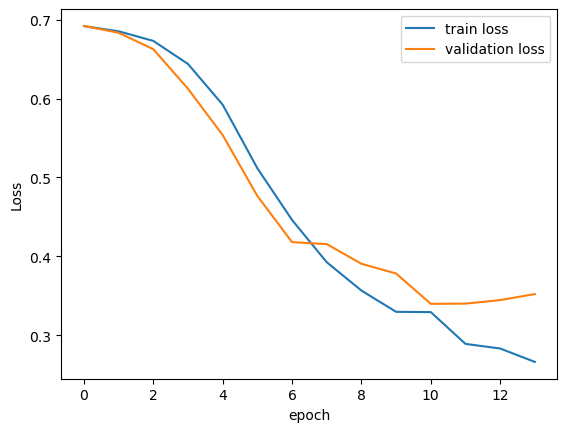

In [9]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

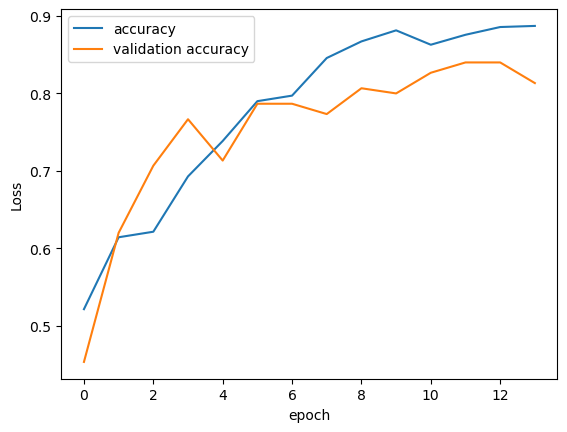

In [10]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

# Testing Evaluation

In [11]:
score, acc = model.evaluate(X_test, Y_test, verbose=2, batch_size=batch_size)
print("score: %.2f" % score)
print("acc: %.2f" % acc)

5/5 - 0s - loss: 0.5960 - accuracy: 0.7467 - 100ms/epoch - 20ms/step
score: 0.60
acc: 0.75


In [12]:
# Calculate the predicted labels for the test data
Y_pred = model.predict(X_test)
Y_pred = np.argmax(Y_pred, axis=1)  # Convert probabilities to class labels
Y_test = np.argmax(Y_test, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(Y_test, Y_pred)
print("Confusion Matrix:")
print(cm)

# Calculate precision, recall, and F1 score
report = classification_report(Y_test, Y_pred)
print("Classification Report:")
print(report)

5/5 [==============================] - 1s 10ms/step
Confusion Matrix:
[[61 10]
 [28 51]]
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.86      0.76        71
           1       0.84      0.65      0.73        79

    accuracy                           0.75       150
   macro avg       0.76      0.75      0.75       150
weighted avg       0.76      0.75      0.74       150



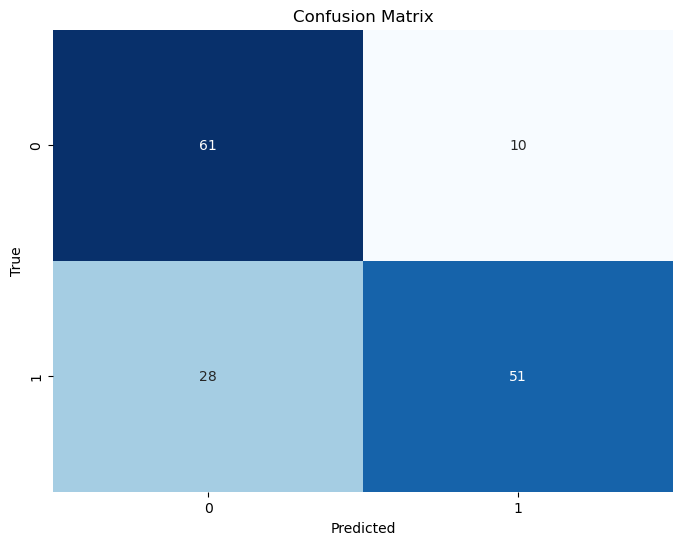

In [13]:
# Visualisation of confusion matrix with heatmap
# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Validation Evaluation

In [14]:
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_validate)):
    
    result = model.predict(X_validate[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]
   
    if np.argmax(result) == np.argmax(Y_validate[x]):
        if np.argmax(Y_validate[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
       
    if np.argmax(Y_validate[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1

print("pos_acc", pos_correct/pos_cnt*100, "%")
print("neg_acc", neg_correct/neg_cnt*100, "%")

1/1 - 0s - 65ms/epoch - 65ms/step
1/1 - 0s - 72ms/epoch - 72ms/step
1/1 - 0s - 67ms/epoch - 67ms/step
1/1 - 0s - 67ms/epoch - 67ms/step
1/1 - 0s - 77ms/epoch - 77ms/step
1/1 - 0s - 67ms/epoch - 67ms/step
1/1 - 0s - 68ms/epoch - 68ms/step
1/1 - 0s - 56ms/epoch - 56ms/step
1/1 - 0s - 69ms/epoch - 69ms/step
1/1 - 0s - 57ms/epoch - 57ms/step
1/1 - 0s - 70ms/epoch - 70ms/step
1/1 - 0s - 49ms/epoch - 49ms/step
1/1 - 0s - 68ms/epoch - 68ms/step
1/1 - 0s - 55ms/epoch - 55ms/step
1/1 - 0s - 33ms/epoch - 33ms/step
1/1 - 0s - 38ms/epoch - 38ms/step
1/1 - 0s - 61ms/epoch - 61ms/step
1/1 - 0s - 73ms/epoch - 73ms/step
1/1 - 0s - 36ms/epoch - 36ms/step
1/1 - 0s - 44ms/epoch - 44ms/step
1/1 - 0s - 66ms/epoch - 66ms/step
1/1 - 0s - 53ms/epoch - 53ms/step
1/1 - 0s - 63ms/epoch - 63ms/step
1/1 - 0s - 79ms/epoch - 79ms/step
1/1 - 0s - 80ms/epoch - 80ms/step
1/1 - 0s - 62ms/epoch - 62ms/step
1/1 - 0s - 62ms/epoch - 62ms/step
1/1 - 0s - 60ms/epoch - 60ms/step
1/1 - 0s - 59ms/epoch - 59ms/step
1/1 - 0s - 40m

# Demo

In [15]:
text = ['the food is good']
#vectorizing the tweet by the pre-fitted tokenizer instance
texts = tokenizer.texts_to_sequences(text)
#padding the tweet to have exactly the same shape as `embedding_2` input
texts = pad_sequences(texts, maxlen=28, dtype='int32', value=0)
print(texts)
sentiment = model.predict(texts,batch_size=1,verbose = 2)[0]

print(f"Text: {text}")
print("Sentiment: ")
if(np.argmax(sentiment) == 0):
    print("negative")
elif (np.argmax(sentiment) == 1):
    print("positive")

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   1 11  7 16]]
1/1 - 1s - 753ms/epoch - 753ms/step
Text: ['the food is good']
Sentiment: 
positive


In [16]:
text = ['the food is very bad']
#vectorizing the tweet by the pre-fitted tokenizer instance
texts = tokenizer.texts_to_sequences(text)
#padding the tweet to have exactly the same shape as `embedding_2` input
texts = pad_sequences(texts, maxlen=28, dtype='int32', value=0)
print(texts)
sentiment = model.predict(texts,batch_size=1,verbose = 2)[0]

print(f"Text: {text}")
print("Sentiment: ")
if(np.argmax(sentiment) == 0):
    print("negative")
elif (np.argmax(sentiment) == 1):
    print("positive")

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1
  11  7 19 95]]
1/1 - 0s - 76ms/epoch - 76ms/step
Text: ['the food is very bad']
Sentiment: 
negative


In [17]:
text = ['both the food and drink were fantastic.']
#vectorizing the tweet by the pre-fitted tokenizer instance
texts = tokenizer.texts_to_sequences(text)
#padding the tweet to have exactly the same shape as `embedding_2` input
texts = pad_sequences(texts, maxlen=28, dtype='int32', value=0)
print(texts)
sentiment = model.predict(texts,batch_size=1,verbose = 2)[0]

print(f"Text: {text}")
print("Sentiment: ")
if(np.argmax(sentiment) == 0):
    print("negative")
elif (np.argmax(sentiment) == 1):
    print("positive")

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0 214   1  11   2  27 146]]
1/1 - 0s - 75ms/epoch - 75ms/step
Text: ['both the food and drink were fantastic.']
Sentiment: 
positive


In [18]:
text = ['The worst food I have ever eaten!']
#vectorizing the tweet by the pre-fitted tokenizer instance
texts = tokenizer.texts_to_sequences(text)
#padding the tweet to have exactly the same shape as `embedding_2` input
texts = pad_sequences(texts, maxlen=28, dtype='int32', value=0)
print(texts)
sentiment = model.predict(texts,batch_size=1,verbose = 2)[0]

print(f"Text: {text}")
print("Sentiment: ")
if(np.argmax(sentiment) == 0):
    print("negative")
elif (np.argmax(sentiment) == 1):
    print("positive")

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   1 123  11   3  30  52]]
1/1 - 0s - 73ms/epoch - 73ms/step
Text: ['The worst food I have ever eaten!']
Sentiment: 
negative


In [19]:
text = ["both the fish and chicken were bad... :("]
#vectorizing the tweet by the pre-fitted tokenizer instance
texts = tokenizer.texts_to_sequences(text)
#padding the tweet to have exactly the same shape as `embedding_2` input
texts = pad_sequences(texts, maxlen=28, dtype='int32', value=0)
print(texts)
sentiment = model.predict(texts,batch_size=1,verbose = 2)[0]

print(f"Text: {text}")
print("Sentiment: ")
if(np.argmax(sentiment) == 0):
    print("negative")
elif (np.argmax(sentiment) == 1):
    print("positive")

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0 214   1   2 102  27  95]]
1/1 - 0s - 63ms/epoch - 63ms/step
Text: ['both the fish and chicken were bad... :(']
Sentiment: 
negative
